In [1]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import sys
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

### Building the model architecture

In [3]:
class DecoderBlockLinkNet(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()

        self.relu = nn.ReLU(inplace=True)

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C/4, 2 * H, 2 * W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        return x
class resnet34(nn.Module):
    def __init__(self, num_classes=1, num_channels=3, pretrained=True):
        super().__init__()
        assert num_channels == 3
        self.num_classes = num_classes
        filters = [64, 128, 256, 512]
        resnet = torchvision.models.resnet34(pretrained=pretrained)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder
        self.decoder4 = DecoderBlockLinkNet(filters[3], filters[2])
        self.decoder3 = DecoderBlockLinkNet(filters[2], filters[1])
        self.decoder2 = DecoderBlockLinkNet(filters[1], filters[0])
        self.decoder1 = DecoderBlockLinkNet(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    # noinspection PyCallingNonCallable
    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
       

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)

#if self.num_classes > 1:
#x_out = F.log_softmax(f5, dim=1)
#else:
#x_out = f5
        return F.softmax(f5, dim=1)


In [4]:
net = resnet34(2).cuda()

In [8]:
print(net)

resnet34(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpl

In [15]:
cv=0
for child in net.children():
    cv+=1
    if cv<9:
        for param in child.parameters():
            param.requires_grad = False
            print(type(param.data),param.size())

<class 'torch.Tensor'> torch.Size([64, 3, 7, 7])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([128, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([128])

In [5]:
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'total':total_num,'trainable':trainable_num}

In [6]:
get_parameter_number(net)

{'total': 21794850, 'trainable': 21794850}

In [36]:
net_vgg16 = torchvision.models.vgg16(pretrained=True).features
net_vgg16.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, ker

In [37]:
m=[0,5,10,17,24]
for i in range(4):
    print(i)
    print(m[i])

0
0
1
5
2
10
3
17


Dataloader

In [7]:
class TSegLoader(torch.utils.data.Dataset):
    def __init__(self, image_folder, mask_folder):
        self.images = os.listdir(image_folder)
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        
# In practice the model performed better without normalisation, 
# Uncomment the line with Normalization if you wish to work with normalised images

        self.tx = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])
        
        self.mx = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x : torch.cat([x,1-x], dim=0))
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        i1 = Image.open(self.image_folder + self.images[i])
        m1 = Image.open(self.mask_folder + self.images[i])
        
        return self.tx(i1), self.mx(m1)

In [8]:
tr = torch.utils.data.DataLoader(TSegLoader('DRIVE2/input_3channel/','DRIVE2/target/'), batch_size=8, shuffle=True)

In [9]:
opt = torch.optim.Adam( filter(lambda p: p.requires_grad, net.parameters()))

### Training 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0 18.35886911302805
1 16.44763743504882
2 15.499847441911697
3 14.997545674443245
4 14.57555741071701
5 14.413657516241074
6 14.271508730947971
7 14.215855292975903
8 14.111461322754622
9 14.011064164340496
10 13.873211190104485
11 13.449072673916817
12 13.351699445396662
13 13.6686853133142
14 13.852025233209133
15 13.49784030020237
16 13.362015001475811
17 13.388249341398478
18 12.890805279836059
19 13.25437649525702


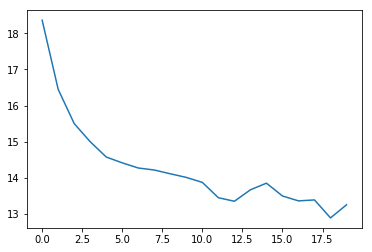

In [12]:
loss_history = []
for i in range(20):
    train_loss = 0.0
    for x, y in tr:
        x, y = x.cuda(),y.cuda()
        opt.zero_grad()
        y_pred = net(x)
        loss = F.mse_loss(y_pred, y)
        train_loss +=loss.item()
        loss.backward()
        opt.step()   
    print (i,train_loss)
    loss_history.append(train_loss)
plt.plot(loss_history)

In [15]:
screen

NameError: name 'screen' is not defined

In [13]:
torch.save(net.state_dict(), 'output_models/torch/unet_resnet34_20.pth')

### Testing phase

In [25]:
torch.cuda.empty_cache()

In [26]:
# Uncomment the line with Normalize if working with Normalized images during training
data_tranform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])

In [27]:
net.load_state_dict(torch.load('output_models/torch/unet_resnet34.pth'))
net.eval();

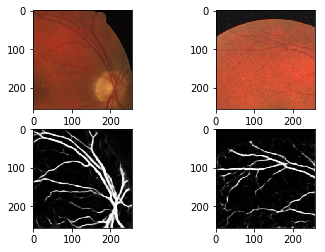

In [31]:
image_id = str(np.random.randint(0,640))
im = Image.open('DRIVE2/input_3channel/' + image_id  + '_orig.jpg')
im_noise = Image.open('DRIVE2/input_3channel/' + image_id  + '_noise.jpg')

s = data_tranform(im).unsqueeze(0)
s = torch.cat((s,data_tranform(im_noise).unsqueeze(0)))

pred= net(s.cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure()
f.add_subplot(2,2, 1)
plt.imshow(im)
f.add_subplot(2,2, 2)
plt.imshow(im_noise)
f.add_subplot(2,2, 3)
plt.imshow(pred[0][0],cmap='gray')
f.add_subplot(2,2, 4)
plt.imshow(pred[1][0],cmap='gray')


### Diabetic retinopathy

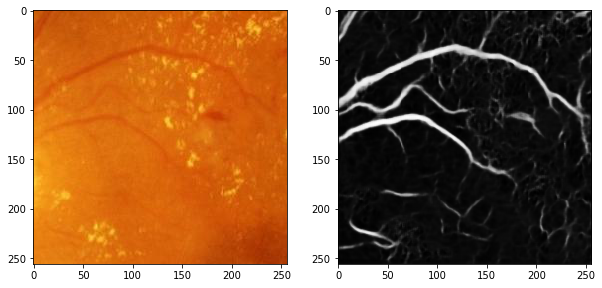

In [0]:
im = Image.open('samples/diabetic-retinopathy-header.jpg')
im = np.asarray(im)
im = im[200:456,400:656]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')

### Pigmentosa

In [0]:
im = Image.open('samples/pigmentosa.jpg')
im = np.asarray(im)
im = im[260:516,350:606]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')

### Haemorrhage

In [0]:
im = Image.open('samples/haemorrhage1.jpg')
im = np.asarray(im)
im = im[0:256,20:276]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')

In [0]:
im = Image.open('samples/haemorrhage2.jpg')
im = np.asarray(im)
im = im[0:256,20:276]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')

In [0]:
im = Image.open('samples/haemorrhage3.png').convert('RGB')
im = np.asarray(im)
im = im[100:356,200:456]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure(figsize=(10,20))
a = f.add_subplot(1,2, 1)
plt.imshow(im)
f.add_subplot(1,2, 2)
plt.imshow(pred[0][0],cmap='gray')